In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

sys.path.append('../../src')
from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.default import PASSING_DEFAULT
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 0
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'surgery_num': '20210903', 'option': 'passing'},
    {'room_num': '08', 'surgery_num': '20210915', 'option': 'passing'},
    {'room_num': '09', 'surgery_num': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    surgery_num = setting['surgery_num']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{surgery_num}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{surgery_num}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'surgery_num': '20210903', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 11.86it/s]


{'room_num': '08', 'surgery_num': '20210915', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 15.24it/s]


{'room_num': '09', 'surgery_num': '20210706', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 22.65it/s]


# keypointsを抽出

In [7]:
min_len = 30

keypoints_dict = {}
for key, ind in individuals.items():
    kps_dict = ind.keypoints  # {frame_num: keypoints}

    if len(kps_dict) > min_len:
        keypoints_dict[key] = kps_dict

## nanを穴埋めする

In [8]:
def fill_nan(keypoints_dict, window=3):
    min_frame_num = min(keypoints_dict.keys())
    max_frame_num = max(keypoints_dict.keys())
    pre = np.array(keypoints_dict[min_frame_num]).reshape(17 * 2)
    
    copy_kps_lst = []
    for frame_num in range(min_frame_num, max_frame_num + 1):
        if frame_num in keypoints_dict:
            kps = np.array(keypoints_dict[frame_num]).reshape(17 * 2)  # (17, 2) -> (34, )
            if True in np.isnan(kps):
                # 一部のnanを前フレームからコピー
                kps = np.where(np.isnan(kps), pre, kps).copy()
            copy_kps_lst.append(kps)
            pre = kps.copy()
        else:
            # 前のフレームからコピー
            copy_kps_lst.append(pre)

    # 残ったnanは移動平均で穴埋め
    ma_kps_lst = []
    for i in range(0, len(copy_kps_lst) - window):
        means = np.nanmean(copy_kps_lst[i:i + window], axis=0)
        for kps in copy_kps_lst[i:i + window]:
            if True in np.isnan(kps):
                kps = np.where(np.isnan(kps), means, kps).copy()

            if len(ma_kps_lst) <= i + window:
                ma_kps_lst.append(kps)

    return  np.array(ma_kps_lst)


keypoints_dict_fill_nan = {}
for key, kps_dict in tqdm(keypoints_dict.items()):
    kps_arr = fill_nan(kps_dict, window=3)
    if len(kps_arr) > 0:
        keypoints_dict_fill_nan[key] = kps_arr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [00:05<00:00, 139.62it/s]


## 標準化

In [9]:
def standardize_kps(kps_arr):
    new_kps_lst = []
    for kps in kps_arr:
        kps = standardize(kps)
        new_kps_lst.append(kps)

    return np.array(new_kps_lst)


keypoints_dict_std = {}
for key, kps_arr in keypoints_dict_fill_nan.items():
    kps_arr = standardize_kps(kps_arr)
    keypoints_dict_std[key] = kps_arr

## 全ての値の分布

In [10]:
hist = []
for kps_arr in keypoints_dict_std.values():
    for kps in kps_arr:
        for val in kps:
            hist.append(val)

5254802


(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 9.00000e+00, 5.00000e+00,
        5.00000e+00, 4.00000e+00, 2.00000e+01, 2.20000e+01, 5.70000e+01,
        1.14000e+02, 1.95000e+02, 2.95000e+02, 1.17300e+03, 1.96100e+03,
        3.95200e+03, 1.52120e+04, 2.74410e+04, 3.32830e+04, 3.59310e+04,
        4.23130e+04, 4.78270e+04, 8.02050e+04, 1.16812e+05, 1.43481e+05,
        1.65854e+05, 1.78274e+05, 1.44725e+05, 1.40189e+05, 1.58572e+05,
        1.56669e+05, 1.59335e+05, 1.37459e+05, 1.31552e+05, 1.15403e+05,
        9.14230e+04, 8.08770e+04, 6.65370e+04, 6.13480e+04, 5.33560e+04,
        4.99190e+04, 4.49720e+04, 4.40120e+04, 4.42980e+04, 4.82380e+04,
        4.87520e+04, 4.93680e+04, 5.20680e+04, 5.19980e+04, 5.30980e+04,
        5.21350e+04, 5.78600e+04, 6.64730e+04, 8.15790e+04, 9.52370e+04,
        1.17591e+05, 1.59569e+05, 2.37009e+05, 3.20807e+05, 3.83289e+05,
        2.80550e+05, 1.60635e+05, 8.99710e+04, 5.95

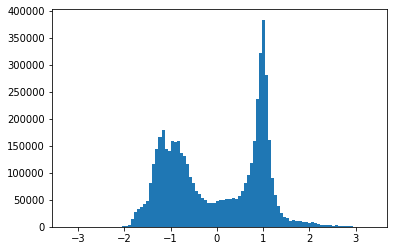

In [11]:
print(len(hist))
plt.hist(hist, bins=100)

# オートエンコーダ

In [12]:
# model settings
SEQ_LEN = 64
Z_SIZE = 64  # feature size
N_LAYERS = 1
DROPOUT = 0.2

# leraning rate
LR = 0.001

# training and data settings
EPOCH = 30
BATCH_SIZE = 64
TRAIN_RATIO = 0.7
VAL_RATIO = 0.05

kwargs = {
    'seq_len': SEQ_LEN,
    'n_features': list(keypoints_dict_std.values())[0].shape[1],
    'hidden_size1': Z_SIZE * 4,
    'hidden_size2': Z_SIZE * 2,
    'z_size': Z_SIZE,
    'n_layers': N_LAYERS,
    'dropout': DROPOUT,
    'lr': LR,
    'epoch': EPOCH,
    'batch_size':BATCH_SIZE,
    'device': device,
}

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット作成

In [13]:
class MyDataset(Dataset):
    def __init__(self, keypoints_dict, keys, **kwargs):
        seq_len = kwargs['seq_len']
        self.x = []
        for key in tqdm(keys):
            kps = keypoints_dict[key]
            for i in range(len(kps) - seq_len + 1):
                self.x.append(kps.tolist()[i:i + seq_len])
            
        self.device = kwargs['device']
            
    def __getitem__(self, index):
        return tensor(self.x[index]).to(self.device)

    def __len__(self):
        return len(self.x)

In [14]:
random_keys = np.random.choice(
    list(keypoints_dict_std.keys()),
    size=len(keypoints_dict_std),
    replace=False
)
train_len = int(len(keypoints_dict_std) * TRAIN_RATIO)
val_len = int(len(keypoints_dict_std) * VAL_RATIO)
train_keys = random_keys[:train_len]
val_keys = random_keys[train_len:train_len + val_len]
test_keys = random_keys[train_len + val_len:]

train_loader = DataLoader(
    MyDataset(keypoints_dict_std, train_keys, **kwargs), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(
    MyDataset(keypoints_dict_std, val_keys, **kwargs), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    MyDataset(keypoints_dict_std, test_keys, **kwargs), batch_size=BATCH_SIZE, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:06<00:00, 33.37it/s]


## モデル生成

In [15]:
class Descriminator(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__()
        self.seq_len = kwargs['seq_len']
        self.n_features = kwargs['n_features']
        self.z_size = kwargs['z_size']

        self.rnn1 = nn.LSTM(
            input_size=kwargs['n_features'],
            hidden_size=kwargs['hidden_size1'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=kwargs['hidden_size1'],
            hidden_size=kwargs['hidden_size2'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=kwargs['hidden_size2'],
            hidden_size=kwargs['z_size'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((-1, self.seq_len, self.n_features))
        # x.shape = (batch_size, seq_len, n_features)
        
        x, (_, _) = self.rnn1(x)
        x, (_, _) = self.rnn2(x)
        _, (z, _) = self.rnn3(x)
        # x.shape = (batch_size, seq_len, z_size)
        # z.shape = (1, batch_size, z_size)
        
        return z.reshape(-1, self.z_size)


class Generator(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__()
        self.seq_len = kwargs['seq_len']
        self.z_size = kwargs['z_size']
        self.n_layers = kwargs['n_layers']

        self.rnn1 = nn.LSTM(
            input_size=kwargs['z_size'],
            hidden_size=kwargs['z_size'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=kwargs['z_size'],
            hidden_size=kwargs['hidden_size2'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=kwargs['hidden_size2'],
            hidden_size=kwargs['hidden_size1'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.output_layer = nn.Linear(kwargs['hidden_size1'], kwargs['n_features'])

    def forward(self, z):
        z = z.repeat(1, self.seq_len).reshape(-1, self.seq_len, self.z_size)
        # z.shape = (batch_size, seq_len, self.z_size)
        
        x, (_, _) = self.rnn1(z)
        x, (_, _) = self.rnn2(x)
        x, (_, _) = self.rnn3(x)
        x = self.output_layer(x)
        # x.shape = (batch_size, seq_len, n_feature)

        return x


class GAN(nn.Module):
    def __init__(self, **kwargs):
        super(RecurrentAutoencoder, self).__init__()

        self.generator = Encoder(**kwargs).to(kwargs['device'])
        self.discriminator = Decoder(**kwargs).to(kwargs['device'])
        
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y, z

In [16]:
# create new model
model = RecurrentAutoencoder(**kwargs)
model = model.to(kwargs['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
criterion = nn.MSELoss().to(kwargs['device'])

model

C:\Users\k2111\program\research\.venv\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(34, 256, batch_first=True, dropout=0.2)
    (rnn2): LSTM(256, 128, batch_first=True, dropout=0.2)
    (rnn3): LSTM(128, 64, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 128, batch_first=True, dropout=0.2)
    (rnn3): LSTM(128, 256, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=34, bias=True)
  )
)

## 学習

In [17]:
n_epochs = kwargs['epoch']
history = dict(train=[], val=[])
for epoch in range(1, n_epochs + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    for x in train_loader:
        optimizer.zero_grad()
        y, _ = model(x)

        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x in val_loader:
            y, _ = model(x)
            loss = criterion(x, y)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{(n_epochs)}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, time: {te - ts:.2f}")

Epoch[1/30] train loss: 0.08481, val loss: 0.08553, time: 30.10
Epoch[2/30] train loss: 0.05476, val loss: 0.08510, time: 27.92
Epoch[3/30] train loss: 0.04245, val loss: 0.07205, time: 27.82
Epoch[4/30] train loss: 0.03074, val loss: 0.06644, time: 27.99
Epoch[5/30] train loss: 0.02409, val loss: 0.05677, time: 28.02
Epoch[6/30] train loss: 0.02028, val loss: 0.06321, time: 27.93
Epoch[7/30] train loss: 0.01734, val loss: 0.05097, time: 27.90
Epoch[8/30] train loss: 0.01484, val loss: 0.04915, time: 28.00
Epoch[9/30] train loss: 0.01319, val loss: 0.04816, time: 27.86
Epoch[10/30] train loss: 0.01207, val loss: 0.04860, time: 27.87
Epoch[11/30] train loss: 0.01088, val loss: 0.04802, time: 27.93
Epoch[12/30] train loss: 0.00982, val loss: 0.04838, time: 27.91
Epoch[13/30] train loss: 0.00977, val loss: 0.04968, time: 27.90
Epoch[14/30] train loss: 0.00907, val loss: 0.04995, time: 27.83
Epoch[15/30] train loss: 0.00809, val loss: 0.04609, time: 27.81
Epoch[16/30] train loss: 0.00811, 

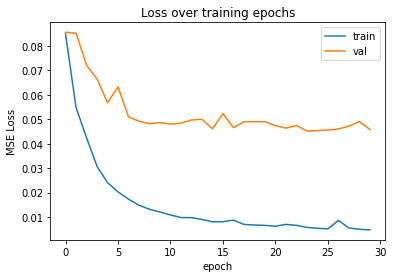

In [18]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

In [19]:
path = f'{common.root}/model/pass_model_autoencoder_{Z_SIZE}.pth'
torch.save(model, path)

## 検証

In [20]:
path = f'{common.root}/model/pass_model_autoencoder_{Z_SIZE}.pth'
model = torch.load(path)
model = model.to(kwargs['device'])

In [21]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(34, 256, batch_first=True, dropout=0.2)
    (rnn2): LSTM(256, 128, batch_first=True, dropout=0.2)
    (rnn3): LSTM(128, 64, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 128, batch_first=True, dropout=0.2)
    (rnn3): LSTM(128, 256, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=34, bias=True)
  )
)

In [22]:
predictions, losses = [], []
with torch.no_grad():
    model = model.eval()
    for x in test_loader:
        y, _ = model(x)

        loss = criterion(x, y)
        predictions.append(y.cpu().numpy().flatten())
        losses.append(loss.item())

0.031167072341452506


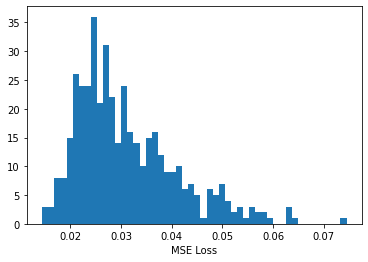

In [23]:
print(np.mean(losses))
plt.hist(losses, bins=50)
plt.xlabel('MSE Loss')
plt.show()

### 特徴量の分布をプロット

In [24]:
# testデータからデータを目視で選択する
print(sorted(test_keys))

['02_01_17', '02_02_0', '02_02_1', '02_02_17', '02_02_25', '02_02_28', '02_02_31', '02_02_33', '02_02_8', '02_02_9', '02_03_17', '02_03_24', '02_03_5', '02_03_7', '02_03_9', '02_04_0', '02_04_14', '02_05_10', '02_05_2', '02_06_7', '02_06_8', '02_06_9', '02_07_4', '02_07_5', '02_08_17', '02_08_5', '02_08_7', '02_08_8', '02_09_10', '02_09_17', '02_09_2', '02_09_3', '02_09_9', '02_10_13', '02_10_14', '02_10_16', '02_10_18', '02_10_19', '02_10_36', '02_10_39', '02_11_3', '02_11_5', '02_11_9', '02_12_1', '02_12_15', '02_12_3', '02_12_4', '02_12_8', '02_13_12', '02_13_2', '02_13_9', '02_14_5', '02_15_0', '02_15_10', '02_15_13', '02_15_3', '02_15_39', '02_15_4', '02_15_44', '02_15_58', '02_16_14', '02_16_3', '02_16_4', '02_16_8', '02_19_3', '02_19_4', '02_20_2', '02_21_0', '02_21_11', '02_21_4', '02_21_5', '02_22_2', '02_22_8', '02_23_10', '02_23_16', '02_23_5', '08_01_1', '08_02_3', '08_02_4', '08_02_5', '08_03_17', '08_03_4', '08_04_0', '08_04_15', '08_05_2', '08_05_5', '08_06_1', '08_06_5'

In [25]:
types = [
    'surgeon',
    'scrub nurse',
    'circulator',
    'anesthesiologist',
    'medical intern',
]
keys = [
    {'key':'02_02_1',  'type':2},
    {'key':'02_02_2',  'type':1},
    {'key':'02_11_0',  'type':4},
    {'key':'02_11_1',  'type':4},
    {'key':'02_11_2',  'type':2},
    {'key':'09_04_3',  'type':2},
    {'key':'09_04_1',  'type':1},
    {'key':'09_04_5',  'type':0},
]

In [26]:
graph = [
    # ========== 4 ============ 9 =========== 14 =====
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Nose
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEye
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REye
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEar
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REar
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # LShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # RShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # LElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # RElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # LHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # RHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # LKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # RKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LAnkle
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RAnkle
]

def plot_keypoints(img, keypoints, color=(255, 0, 0)):
    if np.any(np.isnan(keypoints)):
        return img
    for i in range(len(keypoints) - 1):
        for j in range(i + 1, len(keypoints)):
            p1 = tuple(keypoints[i].astype(int))
            p2 = tuple(keypoints[j].astype(int))
            if graph[i][j] == 1:
                img = cv2.line(img, p1, p2, color, 3)
    return img

[0. 0.] [188.83651032 395.62024973]


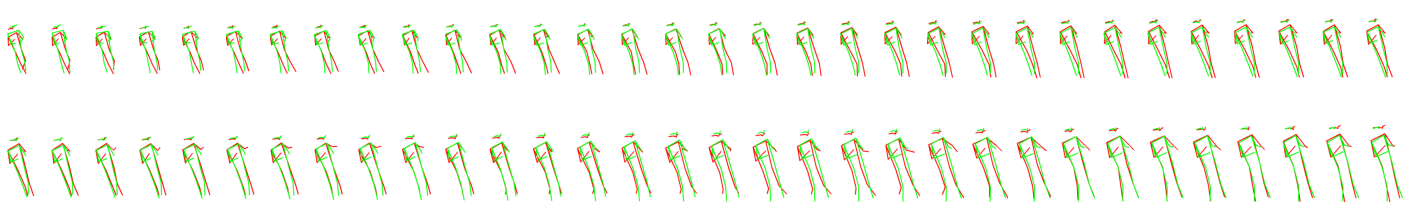

In [48]:
key_idx = 5
frame_num = 64
ratio = 100

keypoints = keypoints_dict_std[keys[key_idx]['key']]
test_keypoints = keypoints[frame_num:frame_num + SEQ_LEN]

model.eval()
with torch.no_grad():
    out, _ = model(tensor(test_keypoints).float().to(kwargs['device']))

    test_keypoints = test_keypoints.reshape(SEQ_LEN, 17, 2)
    out = out.cpu().numpy().flatten().reshape(SEQ_LEN, 17, 2)

    mins = np.min(
        np.append(np.min(test_keypoints, axis=1), np.min(out, axis=1), axis=0),
        axis=0
    )
    
    test_keypoints = (test_keypoints - mins) * ratio
    out = (out - mins) * ratio
    
    mins = np.min(
        np.append(np.min(test_keypoints, axis=1), np.min(out, axis=1), axis=0),
        axis=0
    )
    maxs = np.max(
        np.append(np.max(test_keypoints, axis=1), np.max(out, axis=1), axis=0),
        axis=0
    )
    print(mins, maxs)
    size = (maxs - mins).astype(int)
    
    fig = plt.figure(figsize=(25, 4))
    for i in range(SEQ_LEN):
        ax = fig.add_subplot(2, int(SEQ_LEN / 2), i + 1)
        img = np.ones((size[1], size[0], 3), np.uint8) * 255
        img = plot_keypoints(img, test_keypoints[i, :, :], (255, 0, 0))
        img = plot_keypoints(img, out[i, :, :], (0, 255, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [29]:
n_components = 2

z_lst = []
z_dict = {}
model.eval()
with torch.no_grad():
    for key in tqdm(keys):
        key = key['key']
        kps_arr = keypoints_dict_std[key]
        z_dict[key] = []
        
        for i in range(len(kps_arr) - SEQ_LEN + 1):
            _, z = model(tensor(kps_arr[i:i + SEQ_LEN]).float().to(kwargs['device']))
            z = z.cpu().numpy().flatten()
            z_lst.append(z)
            z_dict[key].append(z)
        
        z_dict[key] = np.array(z_dict[key])

pca = PCA(n_components=n_components)
pca.fit(z_lst)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.29s/it]


PCA(n_components=2)

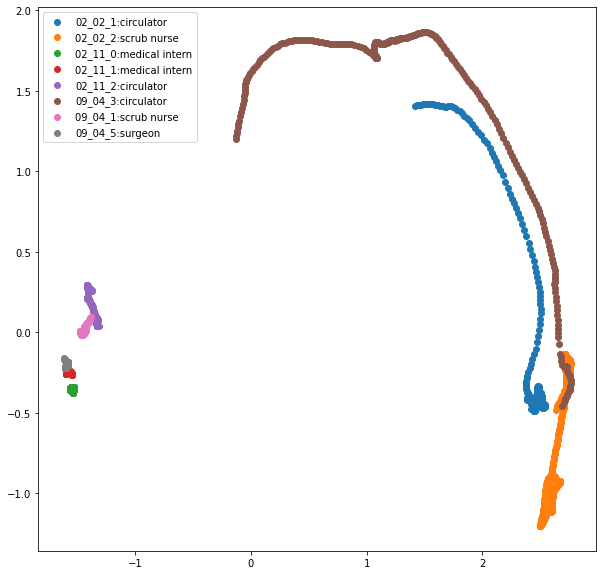

In [30]:
fig = plt.figure(figsize=(10,10))
for key in keys:
    z_lst = z_dict[key['key']]
    z_pca = pca.transform(z_lst)
    x = z_pca.T[0]
    y = z_pca.T[1]
    k, t = key['key'], types[key['type']]
    plt.scatter(x, y, label=f'{k}:{t}')
plt.legend()